# Entraînement des modèles de classification

## 1 - Manipulation et preprocessing des données

On définit une classe pour manipuler le dataset d'images de HappyBud.

In [3]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms_v2
from PIL import Image
import pathlib


class HappyBudDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, subset="train", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file.
            root_dir (str): Root directory containing train, val, and test folders.
            subset (str): One of 'train', 'val', or 'test'.
            transform (callable, optional): Transformations to apply to images.
        """
        self.df = pd.read_csv(
            csv_file,
            index_col=0,
            dtype={
                "filename": str,
                "source": "category",
                "subset": "category",
                "class": "category",
            },
        )

        # Filter dataset based on 'train', 'val', or 'test'
        self.df = self.df[self.df["subset"] == subset]

        # One-hot encoding of labels
        self.labels = pd.get_dummies(self.df["class"])

        self.root_dir = pathlib.Path(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_name = self.df["filename"].iloc[idx]
        img_path = self.root_dir / img_name

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Load labels (convert to tensor)
        labels = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)

        return image, labels


# Define transformations
transform = transforms_v2.Compose(
    [
        transforms_v2.ToImage(),  # Convert to image tensor
        transforms_v2.ToDtype(torch.float32, scale=True),  # Convert dtype to float32
        transforms_v2.Resize((224, 224)),  # Resize images to match model input
    ]
)

# Create dataset
csv_path = "dataset/tomato_dataset_clean_split.csv"
root_dir = "dataset/tomato/"

train_dataset = HappyBudDataset(csv_path, root_dir, subset="train", transform=transform)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test the dataset
for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, 3, 224, 224)
    print(labels.shape)  # Should be (batch_size, num_classes)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 11])


On définit un pipeline pour l'entraînement des données. Ce pipeline se base sur cette
[page](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html)
qui définit les bonnes pratiques pour différentes tâches de vision. On se base aussi en
partie sur le [pipeline](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights)
qui a été utilisé pour entraîner le modèle sur ImageNet1K.

Voici les étapes du pipeline:
- Conversion en tenseur
- Changement du type de données pour float32
- Redimensionnement en images 256x256 (légèrement plus gros que l'entrée)
- Rotation aléatoire
- Réflexion horizontale aléatoire
- Recadrage (crop) aléatoire en 224x224
- Normalisation selon la moyenne et l'écart type de ImageNet1K

In [4]:
# Training pipeline
transformations = [
    # Conversion to float32 image tensor
    transforms_v2.ToImage(),
    transforms_v2.ToDtype(torch.float32, scale=True),
    # Data augmentation
    transforms_v2.Resize((256, 256), antialias=True),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.RandomRotation(
        degrees=(0, 360)
    ),  # , interpolation=transforms_v2.InterpolationMode.BILINEAR),
    transforms_v2.RandomCrop(size=(224, 224)),
    # Normalization for ViT, valeurs de ImageNet1K
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

training_pipeline = transforms_v2.Compose(transformations)

# Pour l'affichage des images, on ne doit pas normaliser
dummy_pipeline = transforms_v2.Compose(transformations[:-1])

Visualisation des images après les transformations.

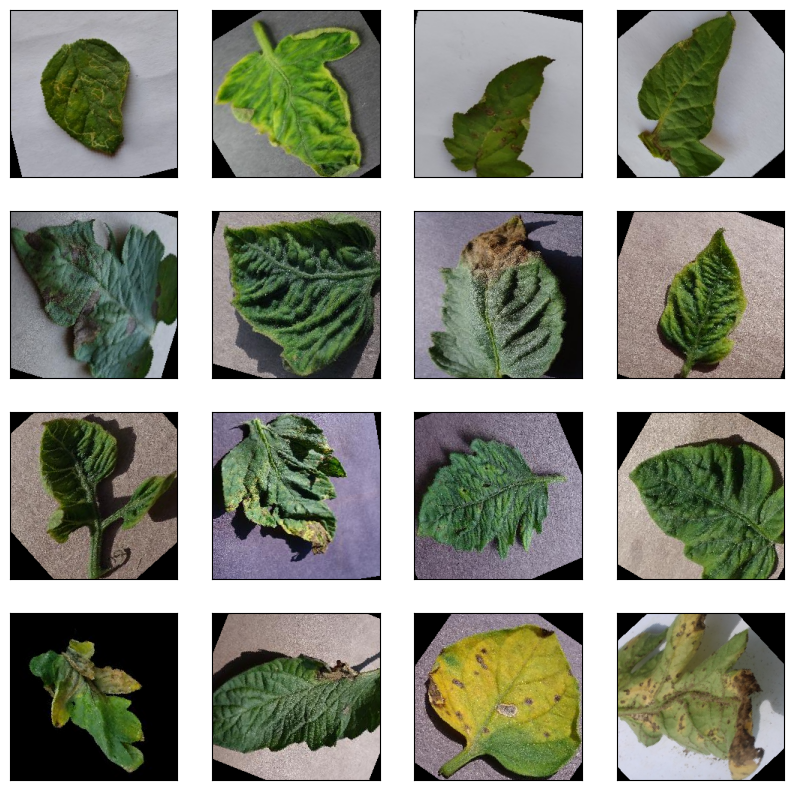

In [5]:
# Visualisation de quelques images après passage du pipeline
import matplotlib.pyplot as plt

dummy_train_dataset = HappyBudDataset(
    csv_path, root_dir, subset="train", transform=dummy_pipeline
)
dummy_train_loader = DataLoader(dummy_train_dataset, batch_size=16, shuffle=True)

images, labels = next(iter(dummy_train_loader))

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, image in enumerate(images):
    ax = axes.flatten()[i]
    ax.imshow(image.moveaxis(0, -1))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

## 2 - Entraînement du modèle

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# import timm
from torchvision.models import vit_b_16

In [7]:
# Create dataset
csv_path = "dataset/tomato_dataset_clean_split.csv"
root_dir = "dataset/tomato/"

# Load datasets
train_dataset = HappyBudDataset(
    csv_file=csv_path, root_dir=root_dir, subset="train", transform=training_pipeline
)
test_dataset = HappyBudDataset(
    csv_file=csv_path, root_dir=root_dir, subset="test", transform=training_pipeline
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Load pretrained ViT
num_labels = len(train_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = vit_b_16(weights="IMAGENET1K_V1")  # Load a pretrained model
model.heads.head = nn.Linear(
    model.heads.head.in_features, num_labels
)  # Modify last layer

In [ ]:
# Calcul du nombre d'images par classes
image_numbers = train_dataset.df["class"].value_counts()[train_dataset.labels.columns]
image_numbers

In [ ]:
# Calcul du poids pour la calibration
weights = torch.tensor(image_numbers.sum() / (image_numbers.values * len(image_numbers)))
weights

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0.0

        for images, labels in train_loader:
            # Compute loss
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Logits
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute number of correct images
            prediction = torch.argmax(outputs, axis=1)
            label = torch.argmax(labels, axis=1)
            correct += (prediction == label).sum()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / len(train_loader.dataset)

        print(
            f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}"
        )


# Train for 10 epochs
train_model(model, train_loader, criterion, optimizer, epochs=10)

In [ ]:
import pathlib

pathlib.Path("models").mkdir(exist_ok=True)

# Save model
torch.save(model.state_dict(), "models/tomato_model_2025_03_11.pt")

## 3 - Validation du modèle sur les données de test

In [8]:
import torch

# Load fine-tuned ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(test_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = vit_b_16()
model.heads.head = nn.Linear(
    model.heads.head.in_features, num_labels
)  # Modify last layer

model.load_state_dict(
    torch.load(
        "models/tomato_model_2025_03_11.pt",
        map_location=device,
        weights_only=True,
    )
)

<All keys matched successfully>

In [11]:
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()  # Set to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No gradients needed
        for images, labels in test_loader:
            model = model.to(device)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, axis=1)
            labels = torch.argmax(labels, axis=1)

            all_labels.append(labels.cpu().numpy())  # Store true labels
            all_preds.append(preds.cpu().numpy())  # Store predictions

    # Convert lists to numpy arrays
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [12]:
# Evaluate model
labels, preds = evaluate_model(model, test_loader, device)

In [13]:
# Accuracy sur les données de test
(labels == preds).sum() / len(labels)

np.float64(0.9156071494379953)

In [14]:
# Copy predictions into dataframe
test_results = test_dataset.df.copy()
assert np.all(test_results["class"].cat.codes == labels)

classes = np.array(test_dataset.labels.columns)

test_results["pred"] = pd.Series(
    pd.Categorical(
        classes[preds],
        categories=classes,
    ),
    index=test_results.index,
)

test_results.to_csv("results/tomato_model_2025_03_11.csv")